### 读入数据集

In [1]:
import numpy as np
import pandas as pda
import matplotlib.pyplot as plt
wine = pda.read_csv("G:\wine-reviews\winemag-data_first150k.csv",header=0,sep='',delimiter=",", encoding='utf-8')

### 1、对数据集进行处理，转换成适合关联规则挖掘的形式

#### 对训练数据进行预处理（包括离散化、缺失值处理）

In [2]:
# 去除 wine数据中的缺失值 
wine = wine.dropna()
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


Points:


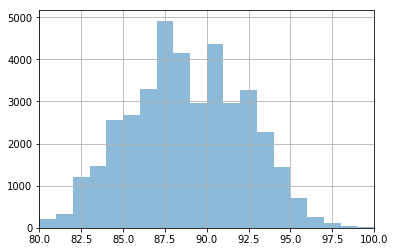

Price:


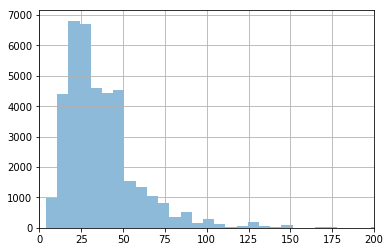

In [3]:
#由于 points 和 price 属性列为连续的数值属性，需要进行离散化处理
# 利用直方图观察数据分布
print("Points:")
#直方图绘制
plt.xlim(80,100)
wine['points'].hist(alpha=0.5,bins=20)
plt.show()

print("Price:")
#直方图绘制
plt.xlim(0,200)
wine['price'].hist(alpha=0.5,bins=300)
plt.show()

In [5]:
# 对数据进行离散化处理
bin = [0,75,80,85,90,95,100]
wine['points'] = pda.cut(wine['points'],bin)
wine['points'] = wine['points'].astype('str')
bin = [0,20,30,40,50,60,210]
wine['price'] = pda.cut(wine['price'],bin)
wine['price'] = wine['price'].astype('str')

#### 根据先验知识去除wine数据集中一些属性，缩小搜索空间

In [6]:
wine = wine.drop(columns=['Unnamed: 0','description'])
wine.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,"(95, 100]",nan,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,US,Special Selected Late Harvest,"(95, 100]","(60.0, 210.0]",California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,"(95, 100]","(60.0, 210.0]",Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,US,Silice,"(90, 95]","(60.0, 210.0]",Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,Gap's Crown Vineyard,"(90, 95]","(50.0, 60.0]",California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


### 2、找出频繁项集

#### 使用Apriori算法提取频繁项集

In [7]:
def createC1( dataSet ):
    """
    构建 频繁 1-项集
    """
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    """
    计算Ck中的项集在数据集合D(记录或者transactions)中的支持度,
    返回满足最小支持度的项集的集合，和所有项集支持度信息的字典。
    """
    ssCnt = {}
    for tid in D:
        # 对于每一条transaction
        if Ck is not None:
            for can in Ck:
                # 对于每一个候选项集can，检查是否是transaction的一部分
                # 即该候选can是否得到transaction的支持
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        # 每个项集的支持度
        support = ssCnt[ key ] / numItems
        
        # 将满足最小支持度的项集，加入retList
        if support >= minSupport:
            retList.insert( 0, key )
            
            # 汇总支持度数据
            supportData[ key ] = support
    return retList, supportData

In [8]:
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D =list( map( set, dataSet ))
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

In [9]:
myDat = list(map(set,np.array(wine)))
L, suppData = apriori(myDat, 0.05)
L

[[frozenset({'(80, 85]'}),
  frozenset({'Red Blend'}),
  frozenset({'Zinfandel'}),
  frozenset({'Paso Robles'}),
  frozenset({'(0.0, 20.0]'}),
  frozenset({'Columbia Valley (WA)'}),
  frozenset({'Russian River Valley'}),
  frozenset({'(85, 90]'}),
  frozenset({'(30.0, 40.0]'}),
  frozenset({'Washington'}),
  frozenset({'Syrah'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Central Coast'}),
  frozenset({'(20.0, 30.0]'}),
  frozenset({'Chardonnay'}),
  frozenset({'(40.0, 50.0]'}),
  frozenset({'(50.0, 60.0]'}),
  frozenset({'(90, 95]'}),
  frozenset({'Willamette Valley'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Oregon'}),
  frozenset({'Sonoma'}),
  frozenset({'(60.0, 210.0]'}),
  frozenset({'US'}),
  frozenset({'Napa Valley'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'})],
 [frozenset({'(20.0, 30.0]', '(80, 85]'}),
  frozenset({'(80, 85]', 'California'}),
  frozenset({'(80, 85]', 'US'}),
  frozenset({'(80, 85]', 'Central Coast'}),
  fr

### 3、导出关联规则，计算其支持度和置信度;

In [12]:
def select_conf(L,suppData,thredhold=0.5):
    confList = []
    for itemSet in L:
            for record in itemSet:
                if(len(record)>1): 
                    for i in record: 
                        tar = suppData[frozenset([i])]
                        bset = record - frozenset([i])
                        aset = suppData[record]
                        ret = suppData.get(bset)
                        try:
                            if suppData.get(bset):
                                con = aset/ret
                                if con > thredhold:
                                    confList.append([frozenset([i]),record,con])
                        except TypeError as e:
                            print(e)

    return confList


confList = select_conf(L,suppData)
confList

[[frozenset({'California'}),
  frozenset({'(80, 85]', 'California'}),
  0.8234507897934387],
 [frozenset({'US'}), frozenset({'(80, 85]', 'US'}), 1.0],
 [frozenset({'US'}), frozenset({'Red Blend', 'US'}), 1.0],
 [frozenset({'California'}),
  frozenset({'California', 'Zinfandel'}),
  0.9762663832801985],
 [frozenset({'US'}), frozenset({'US', 'Zinfandel'}), 1.0],
 [frozenset({'California'}), frozenset({'California', 'Paso Robles'}), 1.0],
 [frozenset({'US'}), frozenset({'Paso Robles', 'US'}), 1.0],
 [frozenset({'Central Coast'}),
  frozenset({'Central Coast', 'Paso Robles'}),
  1.0],
 [frozenset({'California'}),
  frozenset({'(0.0, 20.0]', 'California'}),
  0.6584529676451681],
 [frozenset({'US'}), frozenset({'(0.0, 20.0]', 'US'}), 1.0],
 [frozenset({'(85, 90]'}),
  frozenset({'(0.0, 20.0]', '(85, 90]'}),
  0.5366402399828584],
 [frozenset({'(85, 90]'}),
  frozenset({'(20.0, 30.0]', '(85, 90]'}),
  0.5878959513320746],
 [frozenset({'(85, 90]'}),
  frozenset({'(85, 90]', 'Columbia Valley'}

### 4、对规则进行评价，可使用Lift及其它指标, 要求至少2种；

In [13]:
#Lift相关系数检
def liftCheck(conList,suppData):
    liftList_true=[]
    liftList_no=[]
    liftList_false=[]
    for item in confList:
        score = suppData.get(item[1])/(suppData.get(item[0])*suppData.get(item[1]-item[0]))
        if score>1:
            liftList_true.append(item)
        if score<1:
            liftList_false.append(item)
        if score ==1:
            liftList_no.append(item)
    return liftList_true,liftList_no,liftList_false
yes,no,false = liftCheck(confList,suppData)
yes

[[frozenset({'California'}),
  frozenset({'(80, 85]', 'California'}),
  0.8234507897934387],
 [frozenset({'California'}),
  frozenset({'California', 'Zinfandel'}),
  0.9762663832801985],
 [frozenset({'California'}), frozenset({'California', 'Paso Robles'}), 1.0],
 [frozenset({'Central Coast'}),
  frozenset({'Central Coast', 'Paso Robles'}),
  1.0],
 [frozenset({'(85, 90]'}),
  frozenset({'(0.0, 20.0]', '(85, 90]'}),
  0.5366402399828584],
 [frozenset({'(85, 90]'}),
  frozenset({'(20.0, 30.0]', '(85, 90]'}),
  0.5878959513320746],
 [frozenset({'(85, 90]'}),
  frozenset({'(85, 90]', 'Columbia Valley'}),
  0.5718236819360415],
 [frozenset({'(85, 90]'}),
  frozenset({'(85, 90]', 'Washington'}),
  0.5803658934988566],
 [frozenset({'Columbia Valley'}),
  frozenset({'Columbia Valley', 'Columbia Valley (WA)'}),
  1.0],
 [frozenset({'Washington'}),
  frozenset({'Columbia Valley (WA)', 'Washington'}),
  1.0],
 [frozenset({'California'}),
  frozenset({'(30.0, 40.0]', 'California'}),
  0.755109911

In [14]:
#全自信度检验
def all_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[1])/max(suppData.get(item[0]),suppData.get(item[1]-item[0]))
        result.append(['全自信度为:{0}'.format(score),item])
    return result
all_confidence(confList,suppData)

[['全自信度为:0.2373148439962181',
  [frozenset({'California'}),
   frozenset({'(80, 85]', 'California'}),
   0.8234507897934387]],
 ['全自信度为:0.209729619530593',
  [frozenset({'US'}), frozenset({'(80, 85]', 'US'}), 1.0]],
 ['全自信度为:0.07479422033077648',
  [frozenset({'US'}), frozenset({'Red Blend', 'US'}), 1.0]],
 ['全自信度为:0.09650873691214064',
  [frozenset({'California'}),
   frozenset({'California', 'Zinfandel'}),
   0.9762663832801985]],
 ['全自信度为:0.0719400626895339',
  [frozenset({'US'}), frozenset({'US', 'Zinfandel'}), 1.0]],
 ['全自信度为:0.07336204783415624',
  [frozenset({'California'}), frozenset({'California', 'Paso Robles'}), 1.0]],
 ['全自信度为:0.05338803802145715',
  [frozenset({'US'}), frozenset({'Paso Robles', 'US'}), 1.0]],
 ['全自信度为:0.22896174863387977',
  [frozenset({'Central Coast'}),
   frozenset({'Central Coast', 'Paso Robles'}),
   1.0]],
 ['全自信度为:0.21521868543614525',
  [frozenset({'California'}),
   frozenset({'(0.0, 20.0]', 'California'}),
   0.6584529676451681]],
 ['全自信度为:0.2378